In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import freq_bands_eeg, low_qual_chans, channel_name_dict
from resting_state.settings import *

Change plot theme

In [2]:
sns.set_theme()

Define palettes

In [3]:
palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
palette_gr = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}
palette_gr_lighter = {'DRD2-WT':'#AEC2B3', 'DRD2-KO':'#C68083'}
palette_light = {'DRD2-WT': '#419D78', 'DRD2-KO': '#EB5E55'}

Select folders

In [4]:
epoch_folder = select_folder("Select the folder that holds epoch files starting with 'epochs_w_cluster_annotations_'")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

### Try out on test subject (normalized and absolute PSDs)
Load the epochs of a test subject

In [7]:
subject_id = 39508
epochs = mne.read_epochs(os.path.join(epoch_folder, f"epochs_w_cluster_annotations_{subject_id}-epo.fif"), preload=True)

Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\ploss_thresh_500\epochs_w_cluster_annotations_39508-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.53 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
389 matching events found
No baseline correction applied
0 projection items activated


Get the cluster annotations for this subject

In [8]:
annotations = cluster_annotations[subject_id]
annotations

{'rest': 1, 'sleep': 0, 'active': 2}

In [9]:
np.unique(epochs.metadata.cluster, return_counts=True)[1]

array([211,  26, 152], dtype=int64)

Split the data

In [10]:
resting_epochs = epochs[epochs.metadata["cluster"] == annotations['rest']]
sleep_epochs = epochs[epochs.metadata["cluster"] == annotations['sleep']]
active_epochs = epochs[epochs.metadata["cluster"] == annotations['active']]

Get the channels we want to analyze

In [11]:
wanted_chans = [channel for channel in epochs.info["ch_names"] if not channel in ['EMG_L', 'EMG_R']]
wanted_chans

['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']

In [12]:
df = pd.DataFrame()

for behaviour, epochs in {'resting': resting_epochs, 'sleeping': sleep_epochs, 'active': active_epochs}.items():
    print(f"Generating {behaviour} dataframe.")
    # loop through channels, as we want data per channel

    for channel in wanted_chans:
        for subject_id in epochs.metadata["animal_id"].unique():
            
            subject_data = epochs[epochs.metadata["animal_id"] == subject_id]
            subject_data = subject_data[:-1]  # somehow the last epoch has only 0.0 values, so we remove this
            genotype = subject_data.metadata["genotype"].iloc[0]

            # skip plotting data of bad quality
            if subject_id in low_qual_chans.keys():
                if channel in low_qual_chans[subject_id]: 
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue
            
            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]
            
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)
            
            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "behaviour": behaviour
            })])

Generating resting dataframe.
Generating sleeping dataframe.
Generating active dataframe.


Let's plot the average absolute power of the distinct types of behaviour for all channel. We plot the absolute ones as we're only looking at one animal.

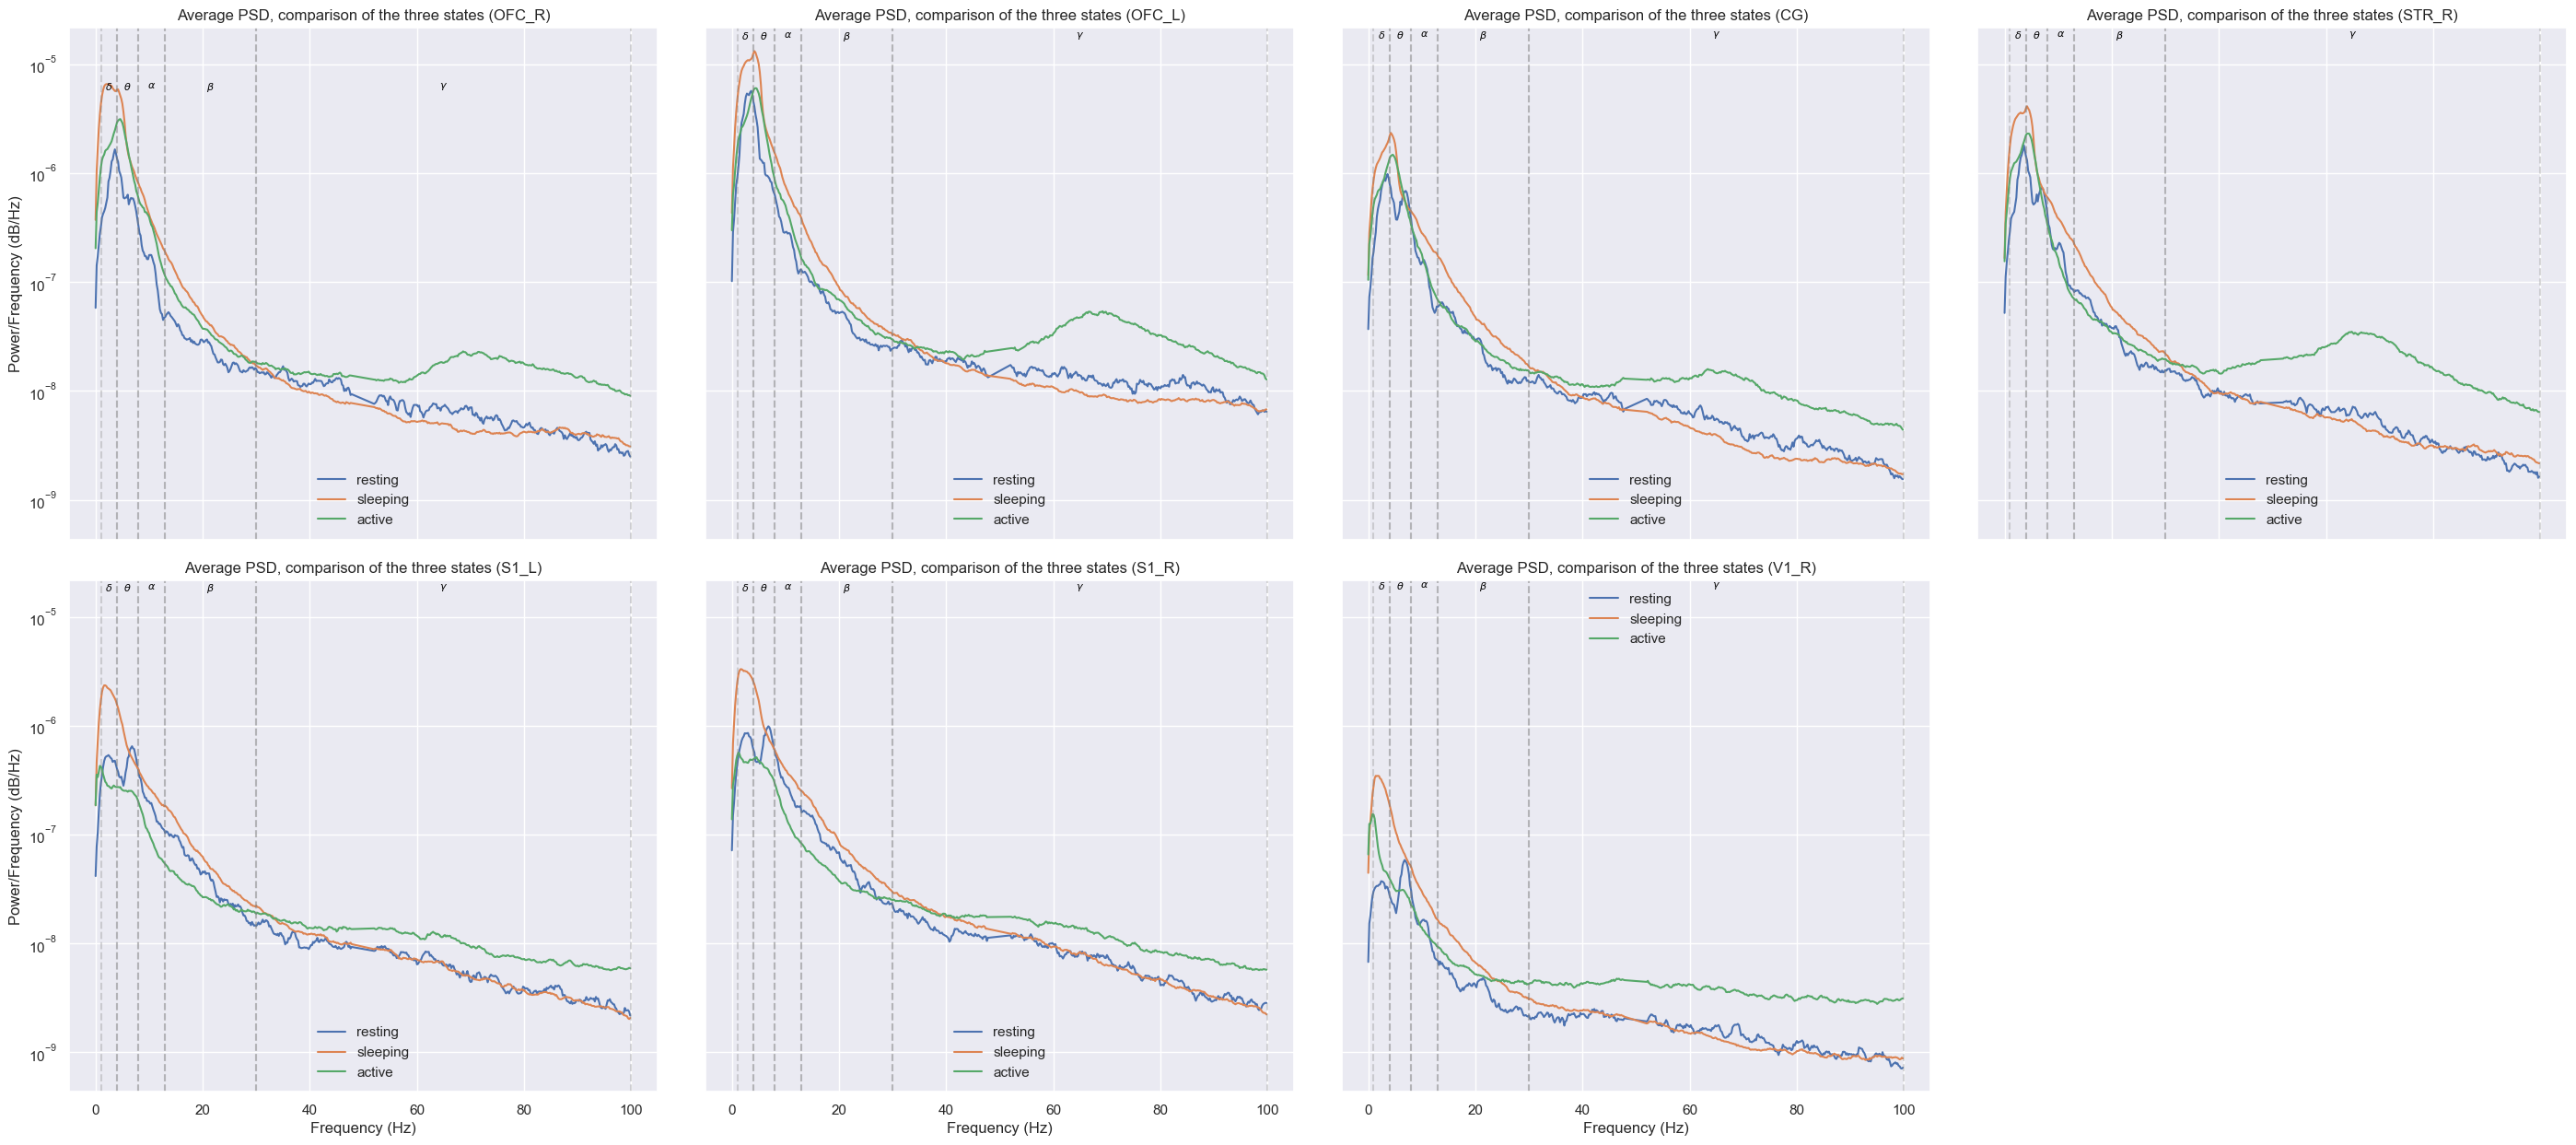

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):
    
    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 52) | (channel_data.freq < 48)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd', hue="behaviour", legend=True, ax=axs[i], errorbar='se')
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(f'Average PSD, comparison of the three states ({channel})')
    axs[i].legend(frameon=False)

plt.subplots_adjust(wspace=0.08, hspace=0.08)
axs[-1].remove()
plt.show()

As one would expect, it is strikingly clear that there are differences between the different kinds of binned behaviours. Active epochs have the highest power across the gamma frequencies (associated with high cognitive function). Sleep epochs, in turn, are highest in power across the delta and theta frequencies.

When it comes to resting epochs, there often seems to be, at least for this animal, a single peak in the high-delta frequencies in the OFCs, and a two-peak kind of dynamic in the other channels (namely a high delta peak, and a high theta frequency peak).

## Working with all animals

First, we load all epochs of the subjects that are not omitted

In [14]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    subj_id = file.split('_')[-1].split('-')[0]
    if not file.startswith('epochs_w_cluster_annotations') or int(subj_id) in omitted_after_clustering:
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

Then we generate a df holding PSD data on all the epochs so we can later plot the PSDs of the DRD2-WTs versus the DRD2-KOs

In [15]:
df = pd.DataFrame()

for i, channel in enumerate(wanted_chans):
    for subject_epochs in all_subject_epochs:
        # slice resting epoch cluster from all non-movement epochs
        subject_id = int(subject_epochs.metadata["animal_id"].iloc[0])
        resting_epochs = subject_epochs[subject_epochs.metadata["cluster"] == cluster_annotations[subject_id]['rest']]
        genotype = resting_epochs.metadata["genotype"].iloc[0]

        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            resting_epochs.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=resting_epochs.info['sfreq'],
            n_jobs=-1,
            normalization='full',
            verbose='WARNING'
        )
        total_power = np.sum(psds_sub, axis=-1)
        psds_sub_norm = psds_sub / total_power[:, np.newaxis]
        
        mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
        mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)

        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd": mean_psd_sub,
            "psd (norm)": mean_psd_sub_norm,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
        })])
        
    print(f"Done with channel {channel}.")

Done with channel OFC_R.
Done with channel OFC_L.
Done with channel CG.
Done with channel STR_R.
Done with channel S1_L.
Done with channel S1_R.
Done with channel V1_R.


Let's inspect a little

In [16]:
print(f'Unique subjects: {df.subject_id.unique()} (n={len(df.subject_id.unique())})')
print(f'The genotypes: {np.unique([df[df.subject_id == subject_id].genotype.iloc[0] for subject_id in df.subject_id.unique()], return_counts=True)}')

Unique subjects: [39489 39508 78211 78227 79592 79593 79602 79604 80620 80625 80630 81175
 81193 81207 81217 81218] (n=16)
The genotypes: (array(['DRD2-KO', 'DRD2-WT'], dtype='<U7'), array([10,  6], dtype=int64))


### To investigate, let's first make a plot for all subject's average channel data

We use the normalized powers as we're now comparing different animals.

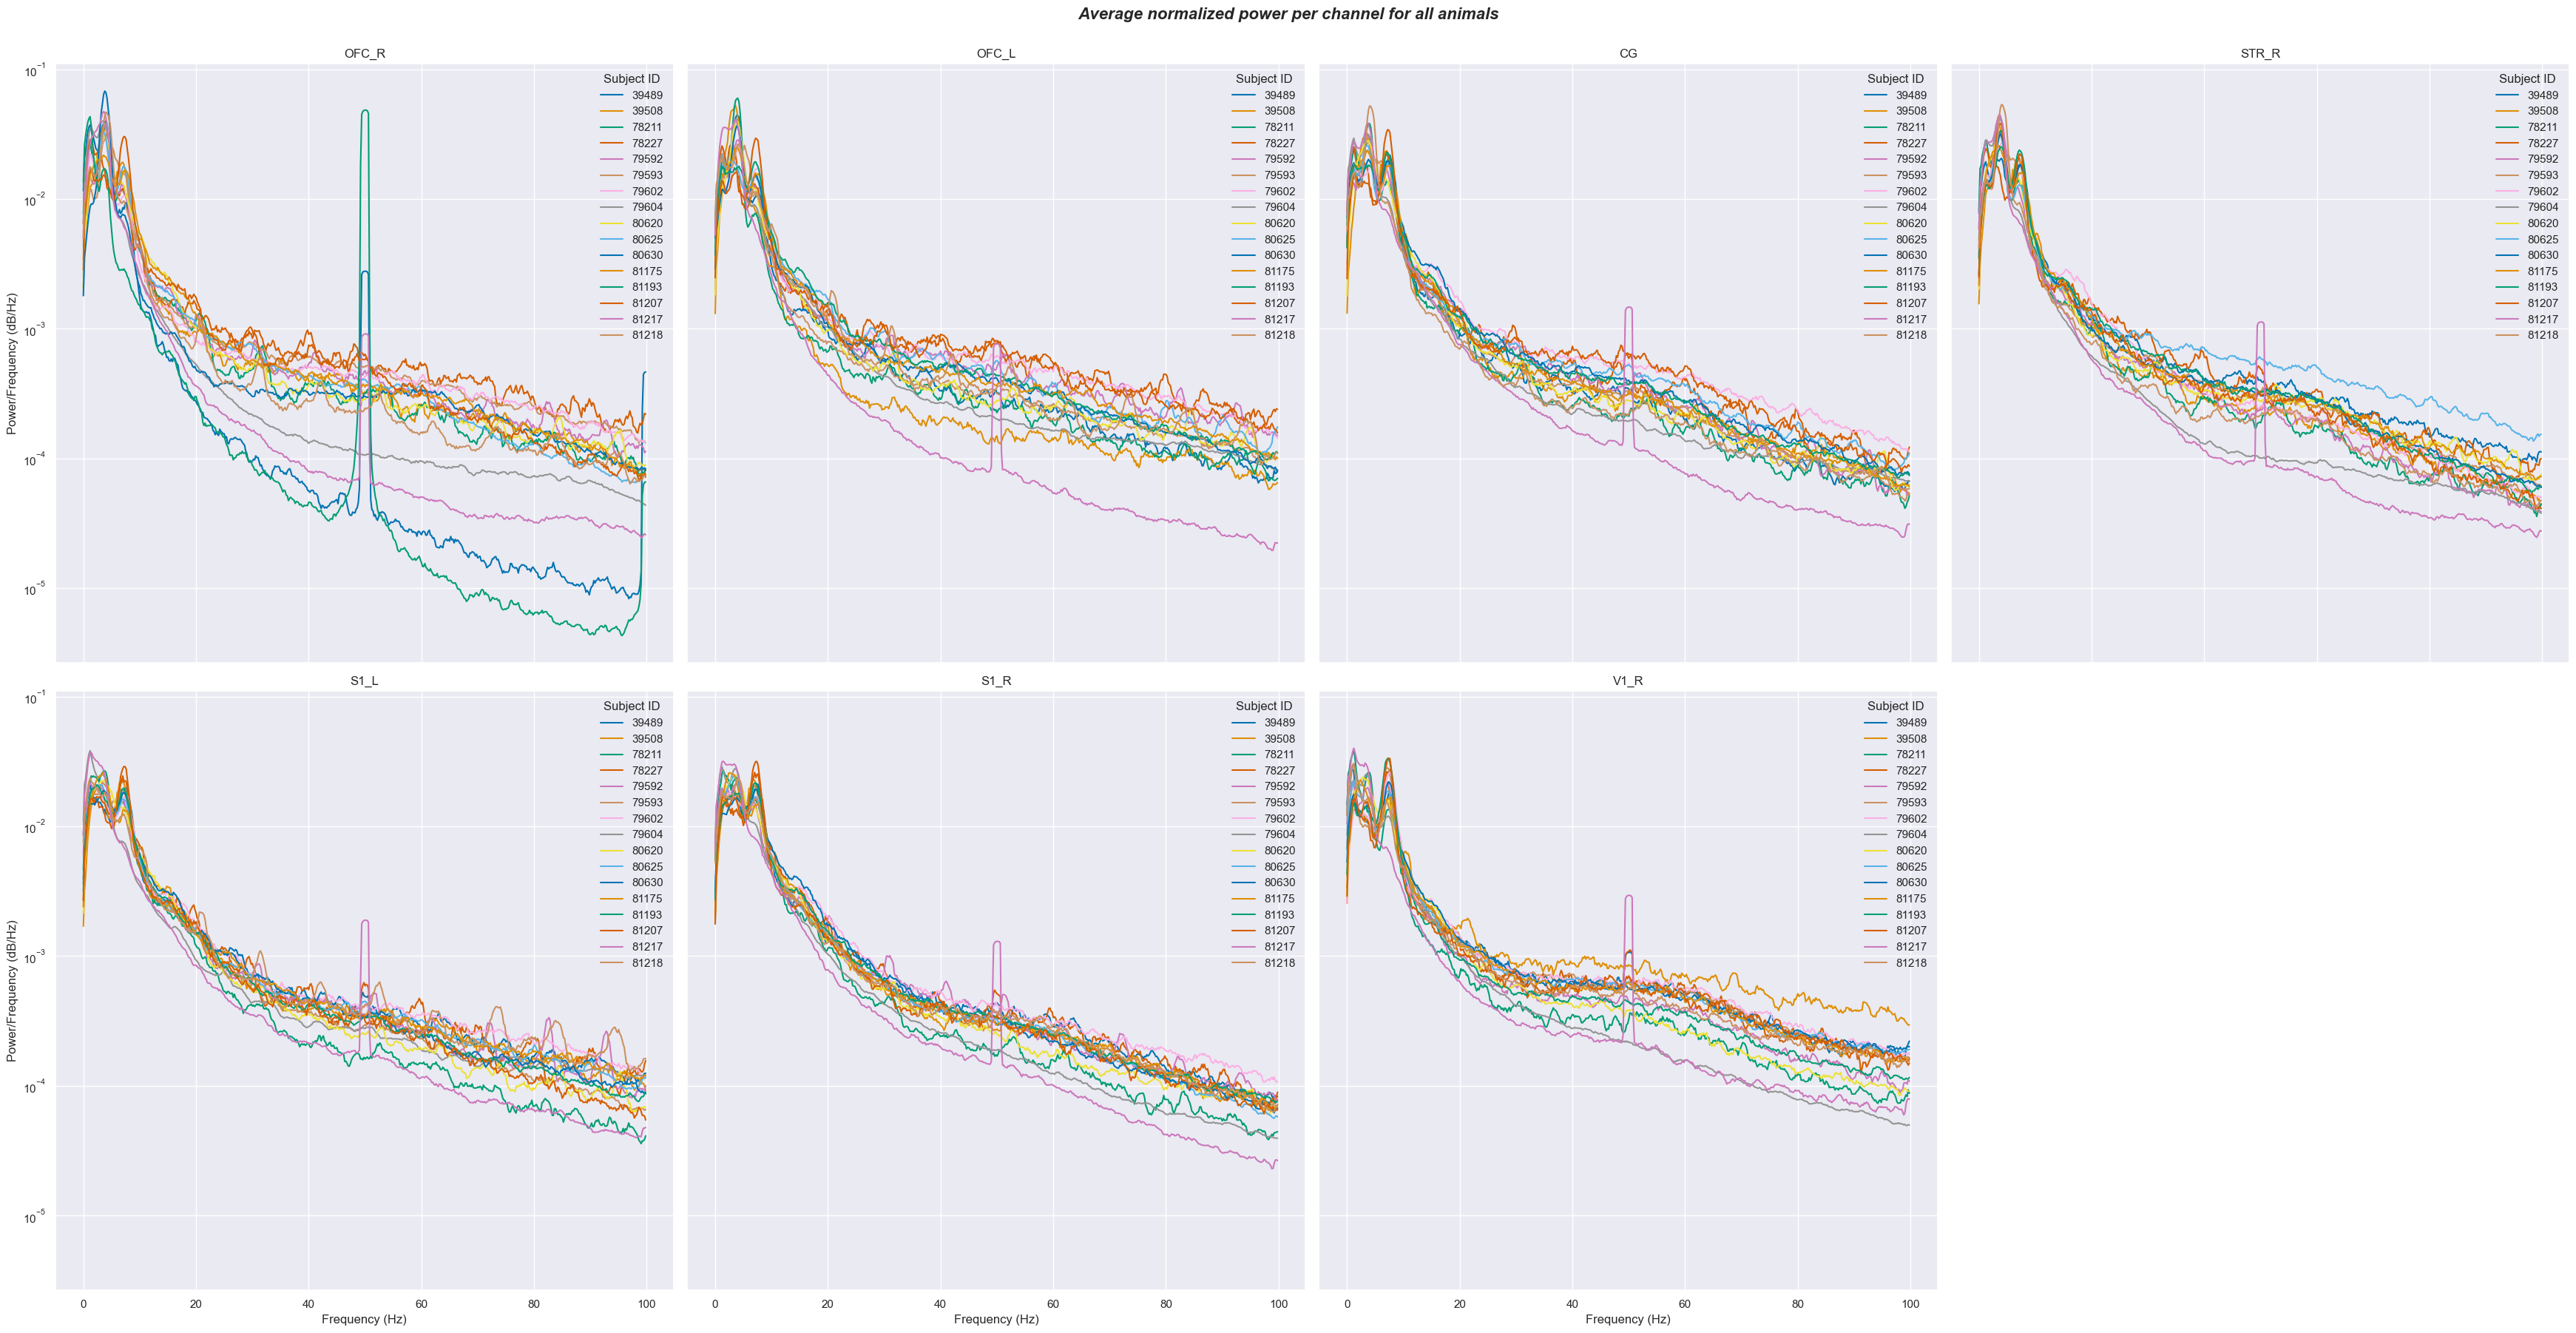

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]

    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', palette=sns.color_palette('colorblind', len(np.unique(df.subject_id))), ax=axs[i], errorbar=None)

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)
    axs[i].legend(title='Subject ID', frameon=False)

plt.suptitle('Average normalized power per channel for all animals', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'average_norm_power_all_subject.pdf'))
plt.show()

After closely observing the average normalized powers for each animal-channel combination, we note the following:

* Subject 81217 seems to be an anomaly, as its average power is below all other subjects across all channels
* Subject 81193's OFC_R channel average is (way too) low compared to other subjects
* Subject 38489's OFC_R channel average is (way too) low compared to other subjects

Therefore, we will remove these channels from further analysis.

In [18]:
print(df.subject_id.unique())

[39489 39508 78211 78227 79592 79593 79602 79604 80620 80625 80630 81175
 81193 81207 81217 81218]


In [19]:
df_wo = df.copy()
df_wo = df_wo[df_wo.subject_id != 81217]
df_wo = df_wo[~((df_wo.subject_id == 81193) & (df_wo.channel == 'OFC_R'))]
df_wo = df_wo[~((df_wo.subject_id == 39489) & (df_wo.channel == 'OFC_R'))]

print(df_wo.subject_id.unique())
print(f'This should be length of zero: {len(df_wo[((df_wo.subject_id == 81193) & (df_wo.channel == "OFC_R"))])}')
print(f'This should be length of zero: {len(df_wo[((df_wo.subject_id == 38489) & (df_wo.channel == "OFC_R"))])}')

[39508 78211 78227 79592 79593 79602 79604 80620 80625 80630 81175 81207
 81218 39489 81193]
This should be length of zero: 0
This should be length of zero: 0


Now theyare removed, let's visualize again

C:\Users\Olle de Jong\AppData\Local\Temp\ipykernel_2928\1072016226.py:8: UserWarning: The palette list has more values (15) than needed (13), which may not be intended.
  sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', palette=sns.color_palette('colorblind', len(np.unique(df_wo.subject_id))), ax=axs[i], errorbar=None)


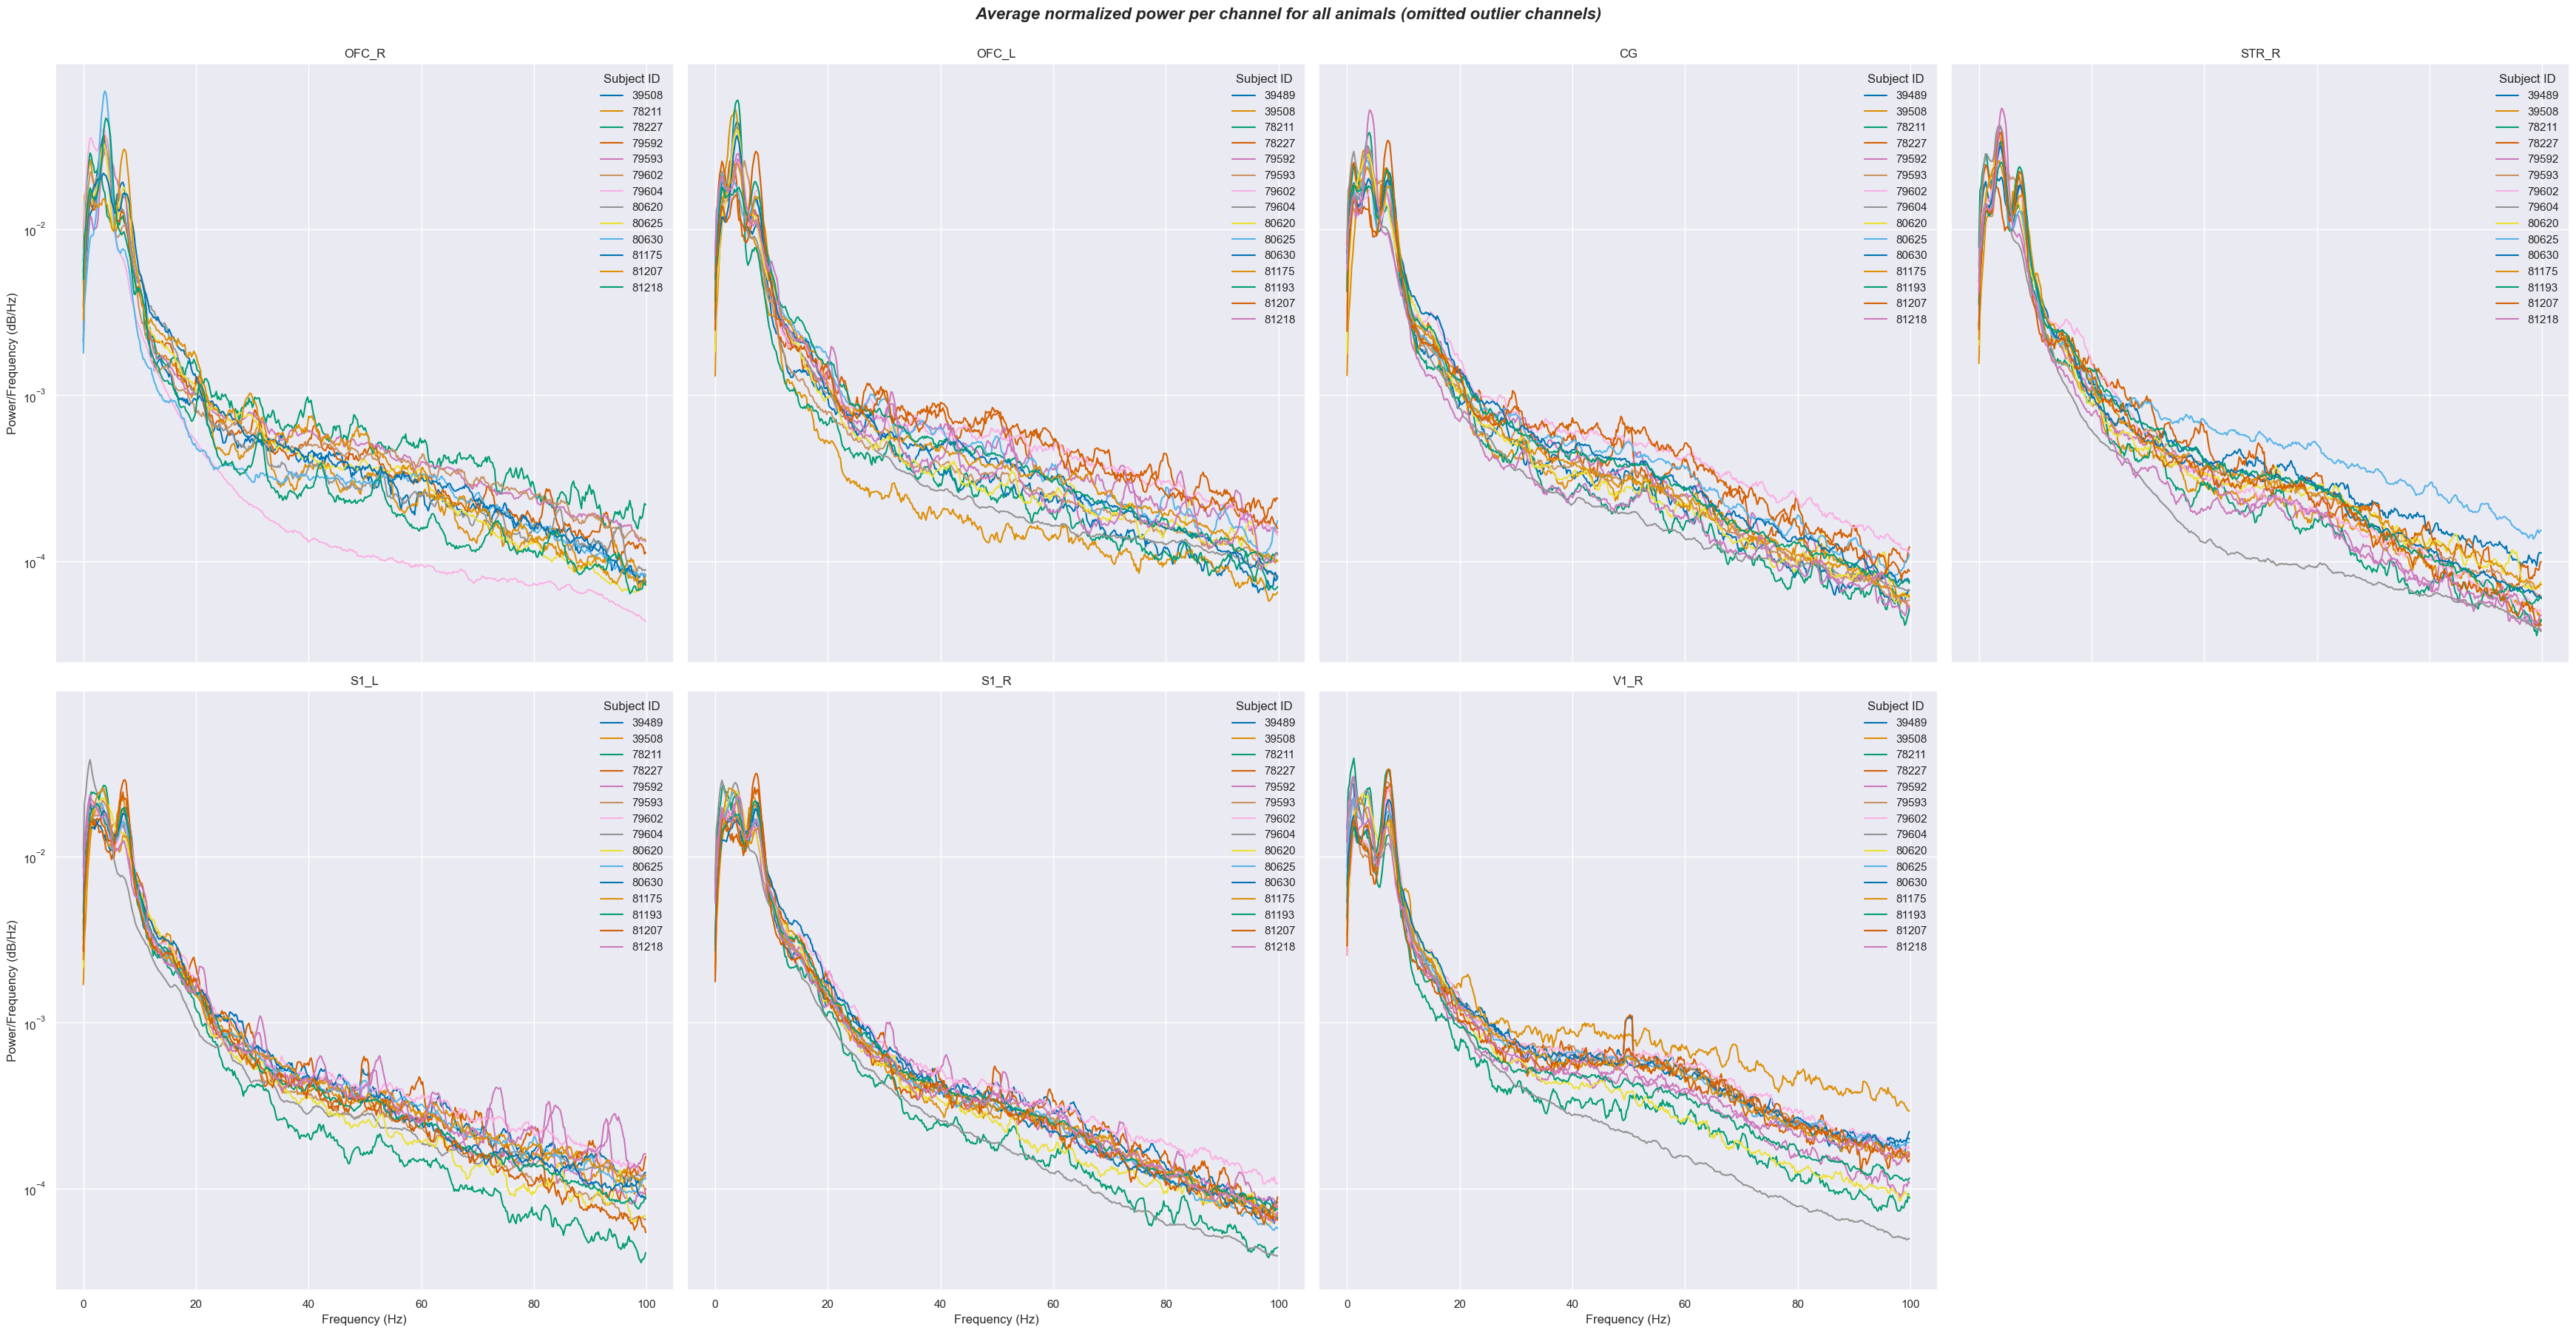

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df_wo[df_wo.channel == channel]

    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', palette=sns.color_palette('colorblind', len(np.unique(df_wo.subject_id))), ax=axs[i], errorbar=None)

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)
    axs[i].legend(title='Subject ID', frameon=False)

plt.suptitle('Average normalized power per channel for all animals (omitted outlier channels)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'average_norm_power_all_subject_wo_outliers.pdf'))
plt.show()

Now that they're removed, we observe that subject 79604 is also quite sketchy, let's remove that as well (note that 79604's color swaps because of removal of subjects from OFC_R).

In [21]:
df_wo = df_wo[df_wo.subject_id != 79604]

print(f'Unique subjects: {np.unique(df_wo.subject_id)}')
print(f'The genotypes: {np.unique([df_wo[df_wo.subject_id == subject_id].genotype.iloc[0] for subject_id in df_wo.subject_id.unique()], return_counts=True)}')

Unique subjects: [39489 39508 78211 78227 79592 79593 79602 80620 80625 80630 81175 81193
 81207 81218]
The genotypes: (array(['DRD2-KO', 'DRD2-WT'], dtype='<U7'), array([9, 5], dtype=int64))


The left-over subjects are listed above. We have 9 knockouts and 5 wildtypes left at this moment.

## DRD2-WT versus DRD2-KO resting-state epoch power over the frequencies

Let's plot the average normalized power per channel, hued on genotype.

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df_wo[df_wo.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak
    
    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', palette=palette_light, hue_order=['DRD2-WT', 'DRD2-KO'], hue='genotype', legend=True, ax=axs[i], errorbar=('ci', 95), linewidth=2.5)
    
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.40)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.40)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=9, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)', fontsize=15)
    axs[i].set_ylabel('Normalized Power (Hz)', fontsize=15)
    axs[i].set_title(channel_name_dict[channel], fontsize=16, fontweight='bold', y=1.01)
    axs[i].legend(title='Genotype', frameon=False)

plt.suptitle('Average normalized power comparison between DRD2-WT and DRD2-KO subjects', fontsize=20, fontweight='bold', fontstyle='italic', y=0.99)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'batched_norm_wt_vs_ko_powers.pdf'))
plt.show()

Now, instead of batching all WT or KO epochs together and averaging power, we will average the power of each subject, and then average the WT subjects their powers and the KO subjects their powers

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

# get the subject's averages for every frequency of each channel 
subject_averages = df_wo.groupby(['subject_id', 'channel', 'freq']).agg({
    'psd': 'mean', 
    'psd (norm)': 'mean',
    'genotype': 'first'
}).reset_index()

for i, channel in enumerate(wanted_chans):

    channel_data = subject_averages[subject_averages.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak

    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette_light)

    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=9, color='black')
    
    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)', fontsize=15)
    axs[i].set_ylabel('Normalized Power (Hz)', fontsize=15)
    axs[i].set_title(channel_name_dict[channel], fontsize=16, fontweight='bold', y=1.01)
    axs[i].legend(title='Genotype', frameon=False)

plt.suptitle('Average normalized power of all DRD2-WT and all DRD2-KO subjects (average of subject averages)', fontsize=20, fontweight='bold', fontstyle='italic', y=0.99)
plt.tight_layout()
axs[-1].remove()
save_figure(os.path.join(plot_folder, 'norm_wt_vs_ko_powers_average_of_subj_averages.pdf'))
plt.show()